In [1]:
import gc
import datetime
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
from lightgbm import early_stopping

warnings.filterwarnings('ignore')

In [2]:
NUM_FOLDS = 5

### Feature
* S_2 이용해서 days 만들기
* customer_ID 당 마지막 데이터 포인트 사용
* 결측치 80% 이상인 특성 제거
* 새로운 특성

In [3]:
def features_process(df, test=False):
    print('days')
    df['S_2'] = pd.to_datetime(df['S_2'])
    df['days'] = (df['S_2'] - df.groupby(['customer_ID'])['S_2'].transform('min')).dt.days.astype('int16') + 1

    print('groupby customer_ID tail(1)')
    df = df.groupby('customer_ID').tail(1).set_index('customer_ID')
    print('shape:', df.shape)

    if not test:
        print('dropna nan >= 80%')
        df = df.dropna(axis=1, thresh=int(0.8 * len(df)))
        print('shape:', df.shape)

    print('feature process')
    df["c_PD_239"] = df["D_39"] / (df["P_2"] * (-1) + 0.0001)
    df["c_PB_29"] = df["P_2"] * (-1) / (df["B_9"] * (1) + 0.0001)
    df["c_PR_21"] = df["P_2"] * (-1) / (df["R_1"] + 0.0001)

    df["c_BBBB"] = (df["B_9"] + 0.001) / (df["B_23"] + df["B_3"] + 0.0001)
    df["c_BBBB1"] = (df["B_33"] * (-1)) + (df["B_18"] * (-1) + df["S_25"] * (1) + 0.0001)
    df["c_BBBB2"] = (df["B_19"] + df["B_20"] + df["B_4"] + 0.0001)

    df["c_RRR0"] = (df["R_3"] + 0.001) / (df["R_2"] + df["R_4"] + 0.0001)
    df["c_RRR1"] = (df["D_62"] + 0.001) / (df["D_112"] + df["R_27"] + 0.0001)

    df["c_PD_348"] = df["D_48"] / (df["P_3"] + 0.0001)
    df["c_PD_355"] = df["D_55"] / (df["P_3"] + 0.0001)

    df["c_PD_439"] = df["D_39"] / (df["P_4"] + 0.0001)
    df["c_PB_49"] = df["B_9"] / (df["P_4"] + 0.0001)
    df["c_PR_41"] = df["R_1"] / (df["P_4"] + 0.0001)
    print('shape:', df.shape)

    return df

### train 데이터 불러오기
* 불러와서 특성 처리

In [4]:
%%time

df_train = pd.read_parquet('./data/train.parquet')
df_train = features_process(df_train)
gc.collect()

days
groupby customer_ID tail(1)
shape: (458913, 190)
dropna nan >= 80%
shape: (458913, 169)
feature process
shape: (458913, 182)
Wall time: 15.2 s


15

### train label 데이터 불러오기
* train 데이터와 병합

In [5]:
df_train_labels = pd.read_csv('./data/train_labels.csv')
df_train = df_train.merge(df_train_labels, how='left', on='customer_ID')
del df_train_labels
gc.collect()
df_train.shape

(458913, 184)

In [6]:
df_train

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,c_BBBB1,c_BBBB2,c_RRR0,c_RRR1,c_PD_348,c_PD_355,c_PD_439,c_PB_49,c_PR_41,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,...,-1.027906,5.0001,10.0,0.223089,0.305605,0.297518,0.0,95.348511,61.037540,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,0.005068,...,-1.022226,1.0001,10010.0,0.117040,0.025737,0.063244,60000.0,129.263092,69.111542,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-12,0.880875,0,0.004284,0.812649,0.006450,NaN,0.0,0.007196,...,-1.027532,2.0001,10.0,0.219482,0.127766,0.157325,0.0,93.920845,64.499542,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2018-03-29,0.621776,0,0.012564,1.006183,0.007829,0.287766,0.0,0.009937,...,-1.025859,0.0001,20010.0,0.217254,NaN,0.031837,0.0,205.261841,78.287788,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2018-03-30,0.871900,0,0.007679,0.815746,0.001247,NaN,0.0,0.005528,...,-0.559481,21.0001,10.0,0.211179,0.569870,0.445327,0.0,40.272621,12.473128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,2018-03-31,0.844229,15,0.028515,1.009866,0.001928,0.128707,0.0,0.005893,...,-1.025454,4.0001,70010.0,0.228755,0.110398,0.066547,150000.0,1702.427612,19.280388,0
458909,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,2018-03-22,0.831279,1,0.292360,0.055656,0.006953,NaN,0.0,0.233078,...,0.878185,111.0001,10010.0,0.047427,0.304541,0.259195,10000.0,1432.067383,69.534317,0
458910,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,2018-03-07,0.800522,9,0.020563,1.007023,0.000957,0.066648,0.0,0.006314,...,-1.027214,6.0001,10.0,0.111633,0.185697,0.173918,90000.0,464.564178,9.573463,0
458911,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,2018-03-23,0.754129,0,0.015838,0.714486,0.000993,0.408849,0.0,0.050048,...,0.513921,21.0001,10.0,0.156583,0.717879,0.611694,0.0,164.913254,9.926709,1


### 평가지표

In [7]:
# https://www.kaggle.com/code/cdeotte/xgboost-starter-0-793/notebook
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):
    
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1] / gini[0] + top_four), _

### 범주형 특성

In [8]:
FEATURES = df_train.columns.drop(['customer_ID', 'S_2', 'target'])
categorical_cols = [
    'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120',
    'D_126', 'D_63', 'D_64', 'D_66', 'D_68'
]

cat_col = []
n = 0
for col in df_train[FEATURES]:
    for coll in categorical_cols:
        if col == coll:
            cat_col.append(n)
            break
    n += 1
cat_col

[44, 45, 50, 52, 91, 129, 136, 138, 139, 142, 148]

### LightGBM 학습
* 5개의 폴드 사용

In [9]:
%%time
params = {}
feature_importances = []  # 특성 중요도 
scores = []               # fold 별 점수 
models = []               # 모델 
pred_val = []
yval = []

# 교차 검증 클래스
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2022)

# 폴드별 데이터 나누기 
for fold, (train_idx, val_idx) in enumerate(skf.split(df_train[FEATURES], df_train["target"])):
    
    print('FOLD:', fold)
    
    # 데이터 나누기
    X_train = df_train.loc[train_idx, FEATURES].values
    y_train = df_train.loc[train_idx, 'target'].values
    X_val = df_train.loc[val_idx, FEATURES].values
    y_val = df_train.loc[val_idx, 'target'].values

    print("y_train t=0 count:", len(y_train[y_train == 0]))
    print("y_train t=1 count:", len(y_train[y_train == 1]))
    print("y_val t=0 count:", len(y_val[y_val == 0]))
    print("y_val t=1 count:", len(y_val[y_val == 1]))


    params = {
        "num_iterations": 10000,
        'learning_rate': 0.05,
    }
    
    # LGBM 알고리즘
    model = lgbm.LGBMClassifier(**params).fit(
        X_train,y_train,
        eval_set=[(X_val, y_val), (X_train, y_train)],
        verbose=100,
        callbacks=[early_stopping(100)],
        categorical_feature=cat_col
    )
    
    # 특성 중요도
    feature_importances.append(model.feature_importances_)   
    models.append(model)
    pred_val = np.append(pred_val, model.predict_proba(X_val)[:, 1])
    yval = np.append(yval, y_val)   
    
    del X_train, y_train, X_val, y_val, model
    gc.collect()


score = amex_metric_mod(yval, pred_val)[0]
print('score:', score)
with open('score_lightgbm_new_feature.txt', 'w') as f:
    f.write(str(score))
# f = open("lightgbm_score.txt", "a")
# f.write(str(score))
# f.close()

FOLD: 0
y_train t=0 count: 272068
y_train t=1 count: 95062
y_val t=0 count: 68017
y_val t=1 count: 23766
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.230569	valid_0's binary_logloss: 0.237005
[200]	training's binary_logloss: 0.217891	valid_0's binary_logloss: 0.228679
[300]	training's binary_logloss: 0.210953	valid_0's binary_logloss: 0.226745
[400]	training's binary_logloss: 0.205689	valid_0's binary_logloss: 0.226254
[500]	training's binary_logloss: 0.200975	valid_0's binary_logloss: 0.225918
[600]	training's binary_logloss: 0.196555	valid_0's binary_logloss: 0.225791
[700]	training's binary_logloss: 0.192394	valid_0's binary_logloss: 0.22574
[800]	training's binary_logloss: 0.188339	valid_0's binary_logloss: 0.225669
[900]	training's binary_logloss: 0.184655	valid_0's binary_logloss: 0.225577
[1000]	training's binary_logloss: 0.180997	valid_0's binary_logloss: 0.225548
Early stopping, best iteration is:
[979]	training's binary_logl

In [10]:
del df_train, train_idx, val_idx, yval, pred_val
gc.collect()

20

### 특성 중요도

       imp0  imp1  imp2  imp3  imp4  mean_imp
P_2     825   751   822   744   760     780.4
S_3     595   527   609   581   501     562.6
D_47    495   461   511   451   424     468.4
P_3     515   430   481   446   406     455.6
D_121   502   414   467   439   439     452.2
...     ...   ...   ...   ...   ...       ...
R_28      0     0     0     0     0       0.0
R_18      0     0     0     0     0       0.0
D_94      0     0     0     0     0       0.0
D_137     0     0     0     0     0       0.0
D_109     0     0     0     0     0       0.0

[181 rows x 6 columns]


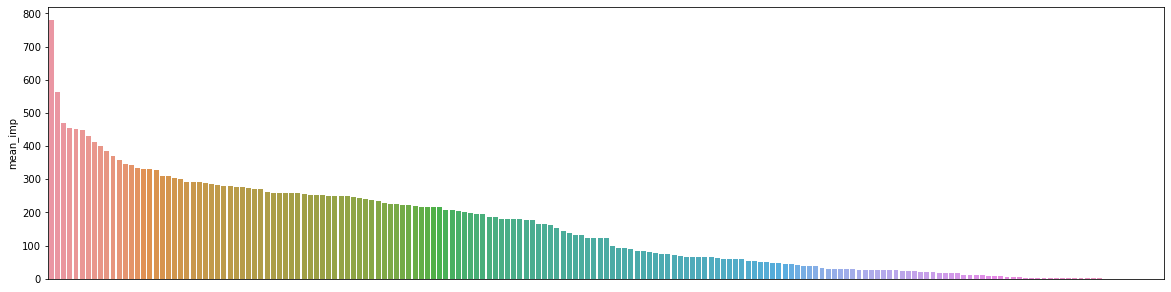

In [11]:
df_feat_imp = pd.DataFrame(index=FEATURES)
df_feat_imp["imp0"] = feature_importances[0]
df_feat_imp["imp1"] = feature_importances[1]
df_feat_imp["imp2"] = feature_importances[2]
df_feat_imp["imp3"] = feature_importances[3]
df_feat_imp["imp4"] = feature_importances[4]
df_feat_imp["mean_imp"] = df_feat_imp.mean(axis=1).values

df_feat_imp = df_feat_imp.sort_values(by="mean_imp",ascending=False)

df_feat_imp.to_csv("feat_imp.csv")

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x=df_feat_imp.index,y=df_feat_imp["mean_imp"])
plt.xticks([])
print(df_feat_imp)

### test 데이터 불러오기

In [12]:
df_test = pd.read_parquet('./data/test.parquet')

df_test = features_process(df_test)
gc.collect()

days
groupby customer_ID tail(1)
shape: (924621, 190)
dropna nan >= 80%
shape: (924621, 170)
feature process
shape: (924621, 183)


62

In [13]:
print("prediction")
pred = []
for fold in range(5):
    print('FOLD:', fold)

    if len(pred) == 0:
        pred = models[fold].predict_proba(df_test[FEATURES])[:, 1]
    else:
        pred += models[fold].predict_proba(df_test[FEATURES])[:, 1]

pred = pred / 5

prediction
FOLD: 0
FOLD: 1
FOLD: 2
FOLD: 3
FOLD: 4


In [14]:
subm = pd.read_csv('./data/sample_submission.csv')
subm["prediction"] = pred
subm.to_csv("submission_lightgbm_new_features_days.csv", index=False)